In [5]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [6]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100).events()

In [28]:
def parton_matching(dr_min=0.5):
    # Select b-quarks at LHE level
    isOutgoing = events.LHEPart.status == 1
    isB = abs(events.LHEPart.pdgId) == 5
    bquarks = events.LHEPart[isB & isOutgoing]

    # Select b-quarks at Gen level, coming from H->bb decay
    if dataset == 'ttHTobb':
        isHiggs = events.GenPart.pdgId == 25
        isHard = events.GenPart.hasFlags(['fromHardProcess'])
        hasTwoChildren = ak.num(events.GenPart.childrenIdxG, axis=2) == 2
        higgs = events.GenPart[isHiggs & isHard & hasTwoChildren]
        bquarks = ak.concatenate( (bquarks, ak.flatten(higgs.children, axis=2)), axis=1 )
        # Sort b-quarks by pt
        bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')

    # Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
    deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
    
    maskDR = deltaR<dr_min
    deltaRcut = deltaR[maskDR]
    idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
    pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]
    pairs_sorted = pairs[idx_pairs_sorted]
    idx_bquarks, idx_Jet = ak.unzip(pairs_sorted)

    hasMatch = ak.zeros_like(idx_Jet, dtype=bool)
    Npairmax = ak.max(ak.num(idx_bquarks))
    # Loop over the (parton, jet) pairs
    for idx_pair in range(Npairmax):
        idx_bquark = ak.pad_none(idx_bquarks, Npairmax)[:,idx_pair]
        idx_match_candidates = idx_Jet[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        idx_pair_candidates  = ak.local_index(idx_Jet)[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
      
        if idx_pair == 0:
            idx_matchedJet    = ak.unflatten( ak.firsts(idx_match_candidates), 1 )
            idx_matchedParton = ak.unflatten( idx_bquark, 1 )
            idx_matchedPair   = ak.unflatten( ak.firsts(idx_pair_candidates), 1 )
        else:
            # If the partons are matched in all events or the number of jets is smaller than the number of partons, stop iterating
            if ak.all( ( (ak.count(idx_matchedJet, axis=1) == ak.count(bquarks.pt, axis=1)) | (ak.count(events.Jet.pt, axis=1) < ak.count(bquarks.pt, axis=1) ) ) ): break
            idx_matchedJet    = ak.concatenate( (idx_matchedJet, ak.unflatten( ak.firsts(idx_match_candidates), 1 ) ), axis=1 )
            idx_matchedParton = ak.concatenate( (idx_matchedParton, ak.unflatten( idx_bquark, 1 )), axis=1 )
            idx_matchedPair   = ak.concatenate( (idx_matchedPair, ak.unflatten( ak.firsts(idx_pair_candidates), 1 ) ), axis=1 )
        # The mask `hasMatch` masks to False the 
        hasMatch = hasMatch | ak.fill_none(idx_Jet == ak.fill_none(ak.firsts(idx_match_candidates), -99), False) | ak.fill_none(idx_bquarks == idx_bquark, False)
   
    idx_matchedParton = idx_matchedParton[~ak.is_none(idx_matchedJet, axis=1)]
    idx_matchedJet = idx_matchedJet[~ak.is_none(idx_matchedJet, axis=1)]
    dr_matchedJet = deltaRcut[idx_pairs_sorted][~ak.is_none(idx_matchedPair, axis=1)]
    idx_matchedPair = idx_matchedPair[~ak.is_none(idx_matchedPair, axis=1)]
    matchedJet    = events.Jet[idx_matchedJet]
    matchedParton = bquarks[idx_matchedParton]
    hasMatchedPartons = ak.count(idx_matchedParton, axis=1) == ak.count(bquarks.pt, axis=1)
    #for cut in self._selections.keys():
    #    print(events.metadata["dataset"], cut, "matched partons =", round(100*ak.sum(hasMatchedPartons[self._cuts.all(*self._selections[cut])])/ak.size(hasMatchedPartons[self._cuts.all(*self._selections[cut])]), 2), "%")
    events["BQuark"] = bquarks
    events["JetMatched"] = matchedJet
    events["BQuarkMatched"] = matchedParton
    events["BQuarkMatched"] = ak.with_field(events.BQuarkMatched, dr_matchedJet, "drMatchedJet")
    return bquarks, matchedJet, idx_matchedJet, idx_matchedParton, idx_matchedPair, dr_matchedJet

In [30]:
dataset = "ttHTobb"
bquarks, matchedJets, idx_matchedJet, idx_matchedParton, idx_matchedPair, dr_matchedJet = parton_matching(0.3)

In [31]:
matchedJets

<JetArray [[Jet, Jet, Jet, ... Jet, Jet, Jet]] type='100 * var * ?jet'>

In [32]:
dr_matchedJet

<Array [[0.026, 0.0406, ... 0.0284, 0.0342]] type='100 * var * ?float32'>

(array([175.,  86.,  34.,  18.,  15.,   9.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.05128205, 0.1025641 , 0.15384615, 0.20512821,
        0.25641026, 0.30769231, 0.35897436, 0.41025641, 0.46153846,
        0.51282051, 0.56410256, 0.61538462, 0.66666667, 0.71794872,
        0.76923077, 0.82051282, 0.87179487, 0.92307692, 0.97435897,
        1.02564103, 1.07692308, 1.12820513, 1.17948718, 1.23076923,
        1.28205128, 1.33333333, 1.38461538, 1.43589744, 1.48717949,
        1.53846154, 1.58974359, 1.64102564, 1.69230769, 1.74358974,
        1.79487179, 1.84615385, 1.8974359 , 1.94871795, 2.        ]),
 <BarContainer object of 39 artists>)

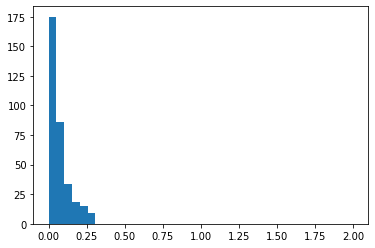

In [33]:
plt.hist(ak.flatten(dr_matchedJet), bins=np.linspace(0,2, 40))